In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nfl_data_py as nfl
from explore import summarize_df, check_missing_values
from transform import filter_to_plays, aggregate_df, add_calc_stats
from model import linreg_evaluate, optimize_alpha, rf_model_evaluate, logreg_model_evaluate
from predict import predict_winner

In [2]:
# range of years to pull from (2003-2023)
years = list(range(2003,2024))

# columns to pull from database
columns =   ['play_id', 'game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type',
             'side_of_field', 'yardline_100', 'game_date', 'game_seconds_remaining', 'down', 'ydsnet', 'desc',
             'play_type', 'yards_gained', 'pass_length', 'yards_after_catch', 'field_goal_result', 
             'kick_distance', 'extra_point_result', 'two_point_conv_result', 'total_home_score', 
             'total_away_score', 'ep', 'epa', 'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 
             'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa', 'wp', 'def_wp', 'home_wp', 
             'away_wp', 'wpa', 'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 
             'total_away_pass_wpa', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
             'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
             'fourth_down_failed', 'incomplete_pass', 'touchback', 'interception', 'fumble_forced', 
             'fumble_not_forced', 'fumble_out_of_bounds', 'safety', 'penalty', 'fumble_lost', 'rush_attempt', 
             'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 
             'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 
             'punt_attempt', 'fumble', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 
             'return_yards', 'penalty_team', 'penalty_yards', 'penalty_type', 'season', 'series_result', 
             'weather', 'play_type_nfl', 'special_teams_play', 'drive_first_downs', 
             'drive_inside20', 'drive_ended_with_score', 'away_score', 'home_score', 'location', 
             'result', 'total', 'spread_line', 'total_line', 'surface', 'temp', 'wind', 'pass', 
             'rush', 'first_down', 'special', 'play', 'qb_epa']

# create df with combined data
df = nfl.import_pbp_data(years, columns, downcast=True)

2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [3]:
# display first n rows, number of rows, number of columns, number of duplicates
summarize_df(df, display_rows=10)


First 10 rows:
   play_id          game_id home_team away_team season_type  week posteam  \
0      1.0  2003_01_ARI_DET       DET       ARI         REG     1    None   
1     35.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
2     57.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
3     78.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
4     99.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
5    120.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
6    141.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
7    160.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
8    178.0  2003_01_ARI_DET       DET       ARI         REG     1     ARI   
9    199.0  2003_01_ARI_DET       DET       ARI         REG     1     ARI   

  posteam_type side_of_field  yardline_100  ... offense_players  \
0         None          None           NaN  ...             NaN   
1 

In [4]:
# display how many nans are in each column (check_missing_values returns df of missing values)
check_missing_values(df, display_rows=500)

                    Column  NA_Count
0    two_point_conv_result    995563
1        field_goal_result    975894
2       extra_point_result    971013
3             penalty_type    926828
4             penalty_team    926808
..                     ...       ...
120                surface         0
121                home_wp         0
122                   pass         0
123                   rush         0
124                play_id         0

[125 rows x 2 columns]


,Column,NA_Count
0,two_point_conv_result,995563
1,field_goal_result,975894
2,extra_point_result,971013
3,penalty_type,926828
4,penalty_team,926808
...,...,...
120,surface,0
121,home_wp,0
122,pass,0
123,rush,0


In [5]:
# filter df to only include plays (gets rid of timeouts, penalties, start of game, etc.)
filtered_df = filter_to_plays(df)

# use one hot encoding on the listed columns
columns_to_encode = ['field_goal_result',
                     'extra_point_result',
                     'two_point_conv_result']
encoded_df = pd.get_dummies(filtered_df, columns=columns_to_encode, drop_first=True)

# columns to group by in aggregate_df
group_by = ['game_id', 'posteam', 'home_team', 'away_team']

# dict of columns to be included in aggregated_df and the corresponding functions to be applied
column_functions = {'yards_gained': 'sum',
                    'receiving_yards': 'sum',
                    'rushing_yards': 'sum',
                    'return_yards': 'sum',
                    'incomplete_pass': 'sum',
                    'complete_pass': 'sum',
                    'interception': 'sum',
                    'pass_attempt': 'sum',
                    'rush_attempt': 'sum',
                    'touchdown': 'sum',
                    'pass_touchdown': 'sum',
                    'rush_touchdown': 'sum',
                    'return_touchdown': 'sum',
                    'first_down': 'sum',
                    'play': 'sum',
                    'sack': 'sum',
                    'fumble': 'sum',
                    'fumble_lost': 'sum',
                    'field_goal_result_made': 'sum',
                    'field_goal_result_missed': 'sum',
                    'extra_point_result_good': 'sum',
                    'extra_point_result_failed': 'sum',
                    'safety': 'sum',
                    'total_home_epa': 'max',
                    'total_away_epa': 'max',
                    'total_home_score': 'max',
                    'total_away_score': 'max',
                    'total': 'max'}

# turn column_functions into a df
df_column_functions = pd.DataFrame(list(column_functions.items()), columns=['Column', 'Function'])

# create aggregated_df
aggregated_df = aggregate_df(encoded_df, group_by, df_column_functions)

# add calculated stats columns (win, season, yards_per_play_offense, points_per_play_offense, 
#                               first_down_rate_offense, turnovers_lost, yards_per_play_allowed, 
#                               points_per_play_allowed, first_down_rate_allowed, turnovers_gained,
#                               turnover_differential, fg percentage, xp percentage)
transformed_df = add_calc_stats(aggregated_df, encoded_df)

c:\Users\alrec\Desktop\DATCAP Repo\DAT-Capstone\transform.py:69: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [45]:
# select features to be used in models
features = ['yards_per_play_offense', 'first_down_rate_offense', 'yards_per_play_allowed', 
            'first_down_rate_allowed', 'turnover_differential']
# select target_variable
target_variable = 'win_percentage_season'

# create X (df of feature columns) and y (series for the target variable)
X = transformed_df[features]
y = transformed_df[target_variable]
    
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create and evaluate linear regression model
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_evaluate(linreg_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.03
Root Mean Squared Error: 0.17
R² Score: 0.14
                   Feature  Coefficient
1  first_down_rate_offense     0.846903
3  first_down_rate_allowed    -0.337724
2   yards_per_play_allowed    -0.013324
4    turnover_differential     0.012198
0   yards_per_play_offense     0.012127


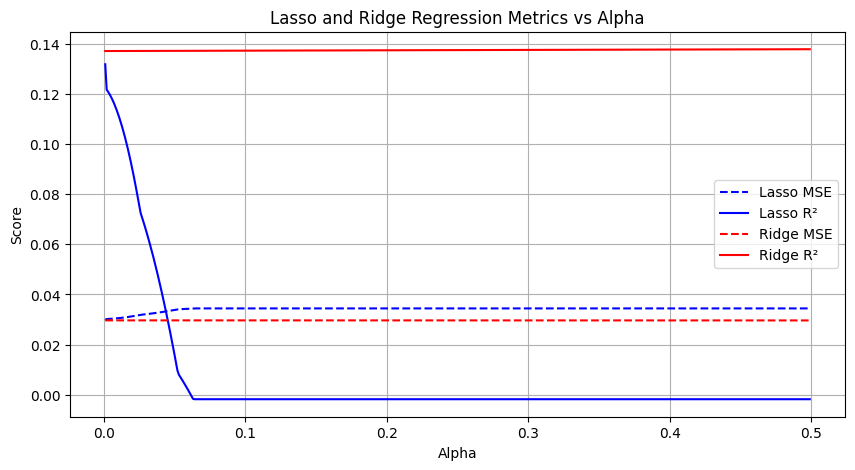

In [46]:
# plot the relationship between alpha and r^2/mse for ridge and lasso models to determine alpha
optimize_alpha(mode='both', features_train=X_train, target_train=y_train, features_test=X_test, target_test=y_test)

In [47]:
# create and evaluate ridge regression model
ridge_model = Ridge(alpha=.05)
ridge_model.fit(X_train, y_train)
linreg_evaluate(ridge_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.03
Root Mean Squared Error: 0.17
R² Score: 0.14
                   Feature  Coefficient
1  first_down_rate_offense     0.843858
3  first_down_rate_allowed    -0.336302
2   yards_per_play_allowed    -0.013365
0   yards_per_play_offense     0.012233
4    turnover_differential     0.012199


In [48]:
# create and evaluate lasso regression model
lasso_model = Lasso(alpha=.01)
lasso_model.fit(X_train, y_train)
linreg_evaluate(lasso_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.03
Root Mean Squared Error: 0.17
R² Score: 0.11
                   Feature  Coefficient
0   yards_per_play_offense     0.033386
2   yards_per_play_allowed    -0.013692
4    turnover_differential     0.011164
1  first_down_rate_offense     0.000000
3  first_down_rate_allowed    -0.000000


In [10]:
# create and evaluate random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_model_evaluate(rf_model, features_test=X_test, target_test=y_test, tree_plot=False, feature_importance=False)

Accuracy: 0.8221
Confusion Matrix:
[[904 206]
 [197 958]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1110
           1       0.82      0.83      0.83      1155

    accuracy                           0.82      2265
   macro avg       0.82      0.82      0.82      2265
weighted avg       0.82      0.82      0.82      2265



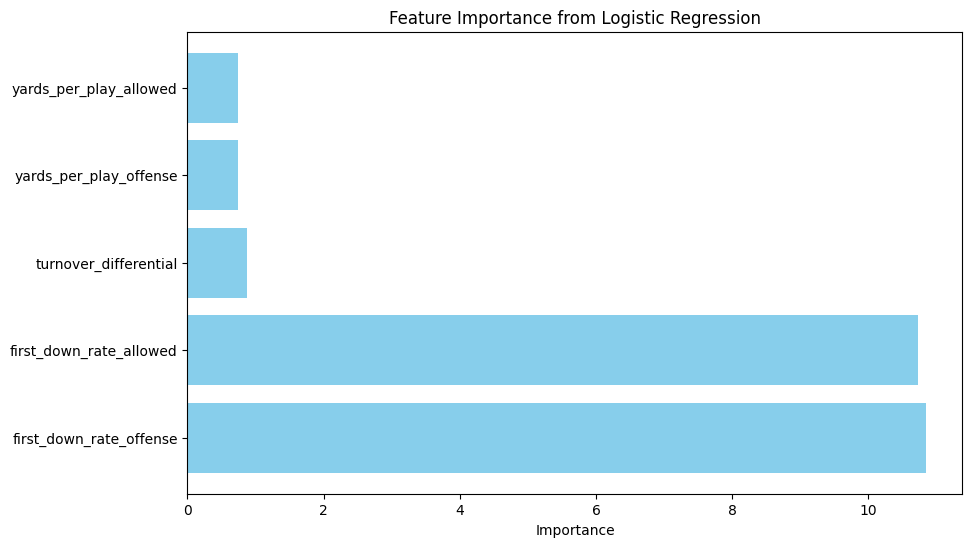

       Actual  Predicted  Probability
1250        0          1     0.875662
2816        0          0     0.470915
6014        1          1     0.969056
5781        1          1     0.538742
10520       0          0     0.025497
1807        0          0     0.035075
1121        1          1     0.971875
10916       1          1     0.975867
1383        0          1     0.667403
4060        0          0     0.076586


In [11]:
# create and evaluate logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
print(logreg_model_evaluate(logreg_model, X_test, y_test, feature_importance=True).head(10))

In [12]:
# load the current season's play by play data
df_current = nfl.import_pbp_data([2024], columns, downcast=True)

# create filtered_df_current
filtered_df_current = filter_to_plays(df_current)

# create encoded_df_current
encoded_df_current = pd.get_dummies(filtered_df_current, columns=columns_to_encode, drop_first=True)

# create aggregated_df_current
aggregated_df_current = aggregate_df(encoded_df_current, group_by, df_column_functions)

# create transformed_df_current
transformed_df_current = add_calc_stats(aggregated_df_current, encoded_df_current)

2024 done.
Downcasting floats.


c:\Users\alrec\Desktop\DATCAP Repo\DAT-Capstone\transform.py:69: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [13]:
# column functions parameter for aggregate_df the second time
column_functions = {'turnover_differential': 'mean',
                    'first_down_rate_allowed': 'mean',
                    'first_down_rate_offense': 'mean',
                    'yards_per_play_allowed': 'mean',
                    'yards_per_play_offense': 'mean'}
df_column_functions = pd.DataFrame(list(column_functions.items()), columns=['Column', 'Function'])

# aggregate season_team_df
season_team_df_2024 = aggregate_df(transformed_df_current, ['posteam'], df_column_functions)

c:\Users\alrec\Desktop\DATCAP Repo\DAT-Capstone\transform.py:69: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [14]:
# identify features from season_team_df_current
features = season_team_df_2024[['yards_per_play_offense', 'first_down_rate_offense', 'yards_per_play_allowed', 
                                'first_down_rate_allowed', 'turnover_differential']]

# scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# create scaled_df_current
scaled_df_2024 = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df_2024['posteam'] = season_team_df_2024['posteam']
scaled_df_2024 = scaled_df_2024.reset_index(drop=True)

In [60]:
# predict the winner of an nfl game
home = 'BUF'
away = 'NYJ'
predicted_winner, winning_probability = predict_winner(logreg_model, scaled_df_2024, home, away)
print(f"Predicted Winner: {predicted_winner}, Probability: {winning_probability:.2f}%")

Predicted Winner: NYJ, Probability: 99.98%


In [16]:
# download any models or datasets
print("Would you like to save any files from the project? (y/n)")
i = input("")
if i in {'Y','y', 'ex'}:
    print("Would you like to save the models to a folder? (y/n)")
    print("ex = 'C:\\Users\\alrec\\Desktop\\DATCAP Repo\\models'")
    i = input("")
    if i in {'Y','y', 'ex'}:
        if i == 'ex':
            filepath = r'C:\Users\alrec\Desktop\DATCAP Repo\models'
        else:
            filepath = input("Please enter the filepath for the folder to save to: ")
        os.makedirs(filepath, exist_ok=True)
        joblib.dump(linreg_model, f'{filepath}\linreg_model.pkl')
        joblib.dump(ridge_model, f'{filepath}/ridge_model.pkl')
        joblib.dump(lasso_model, f'{filepath}\lasso_model.pkl')
        joblib.dump(rf_model, f'{filepath}/rf_model.pkl')
        print('models saved')
    
    print("Would you like to save the data to a folder? (y/n)")
    i = input("").strip()

    if i in {'Y', 'y', 'ex'}:
        if i == 'ex':
            filepath = r'C:/Users/alrec/Desktop/DATCAP Repo/data'
        else:
            filepath = input("Please enter the filepath for the folder to save to: ").strip()
        
        os.makedirs(filepath, exist_ok=True)
        
        df.to_csv(os.path.join(filepath, 'df.csv'), index=False)
        filtered_df.to_csv(os.path.join(filepath, 'filtered_df.csv'), index=False)
        aggregated_df.to_csv(os.path.join(filepath, 'aggregated_df.csv'), index=False)
        transformed_df.to_csv(os.path.join(filepath, 'transformed_df.csv'), index=False)

        print('Data saved successfully')


Would you like to save any files from the project? (y/n)
